<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-Projects/blob/main/Email%20Spam%20Detection/email_spam_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset

In [29]:
from google.colab import userdata

import os
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

In [30]:
!kaggle datasets download zeeshanyounas001/email-spam-detection
!unzip email-spam-detection.zip

Dataset URL: https://www.kaggle.com/datasets/zeeshanyounas001/email-spam-detection
License(s): apache-2.0
email-spam-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  email-spam-detection.zip
replace spam mail.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: spam mail.csv           
  inflating: spam.csv                


# Import Libraries

In [57]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score)
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, LSTM,
                                     Dense, Dropout, Bidirectional)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [32]:
# Download NLTK
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading Dataset

In [33]:
df = pd.read_csv("/content/spam mail.csv")

# Analyzing Dataset

In [34]:
df.head()

,Category,Masseges
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Masseges  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [36]:
df.Category.value_counts()

,count
Category,
ham,4825
spam,747


In [37]:
# Analyze lengths
df['message_len'] = df['Masseges'].apply(lambda x: len(str(x).split()))

# Check data
print(f"Max message length: {max(df['message_len'])}")
print(f"Min message length: {min(df['message_len'])}")

Max message length: 171
Min message length: 1


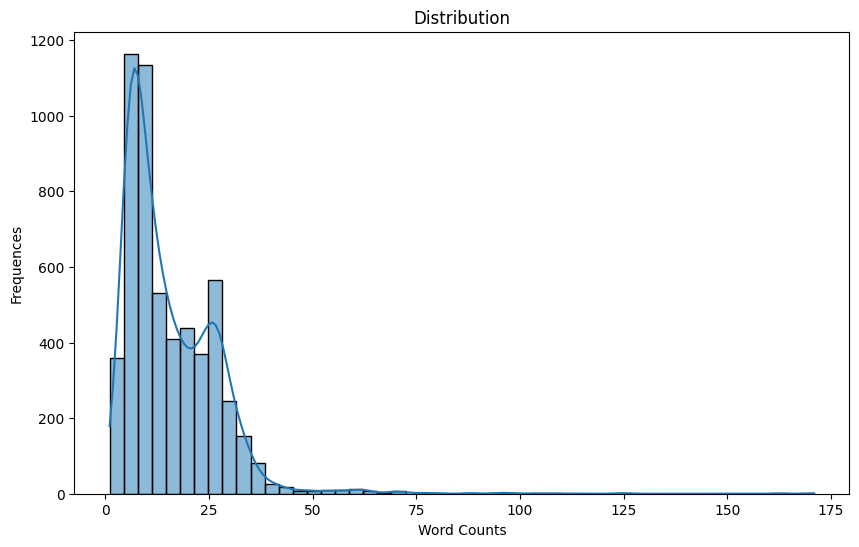

In [38]:
plt.figure(figsize=(10, 6))
sns.histplot(df['message_len'], bins=50, kde=True)
plt.title("Distribution")
plt.xlabel("Word Counts")
plt.ylabel("Frequences")
plt.show()

# Text Cleaning

In [39]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text


In [40]:
df['Masseges'] = df['Masseges'].apply(preprocess_text)

In [41]:
df = df[df['Masseges'].str.strip() != '']
print(f"Sample counts after removing empty messages: {len(df)}")

Sample counts after removing empty messages: 5566


In [42]:
df['Category'] = df['Category'].map({'spam': 0, 'ham': 1})

# Separate `sentences` And `labels`

In [43]:
sentences = df["Masseges"].values
labels = df["Category"].values

print(f"Label types: {labels.dtype}")
print(f"Unique Labels: {np.unique(labels)}")

Label types: int64
Unique Labels: [0 1]


# Check Data Statistics

In [44]:
print(f"Max sequence length: {max([len(sentence.split()) for sentence in sentences])}")
print(f"Min sequence length: {min([len(sentence.split()) for sentence in sentences])}")

s = sorted([len(sentence.split()) for sentence in sentences])
print(f"Median sequence length: {s[len(s) // 2]}")

Max sequence length: 80
Min sequence length: 1
Median sequence length: 7


# Configuration

In [45]:
MAX_SEQUENCES_LENGTH = 60
MAX_VOCAB_SIZE = 5000
EMBEDDING_DIM = 64
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
EPOCHS = 20
L2_REG = 0.005
DROPOUT_RATE = 0.3

# Tokenization

In [46]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

# Get word2idx
word2idx = tokenizer.word_index
print(f"Found {len(word2idx)} unique tokens.")

Found 8472 unique tokens.


# Padding

In [47]:
data_tensor = pad_sequences(sequences, maxlen=MAX_SEQUENCES_LENGTH,
                            padding="post", truncating="post")

print(f"Shape of data tensors: {data_tensor.shape}")

Shape of data tensors: (5566, 60)


# Split Train/Test

In [48]:
X = data_tensor
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of train data: {X_train.shape}")
print(f"Shape of test data: {X_test.shape}")

Shape of train data: (4452, 60)
Shape of test data: (1114, 60)


# Handling Class Imbalance

In [49]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class Weights:", class_weight_dict)

Class Weights: {0: np.float64(3.6372549019607843), 1: np.float64(0.5796875)}


# Define Model

In [50]:
# Input Layer
input_layer = Input(shape=(MAX_SEQUENCES_LENGTH,), name="input_layer")

# Embedding
embedding_layer = Embedding(input_dim=min(MAX_VOCAB_SIZE, len(word2idx) + 1),
                            output_dim=EMBEDDING_DIM,
                            trainable=True,
                            name="embedding_layer")(input_layer)

# LSTM 1
lstm1 = Bidirectional(LSTM(units=128,
                           return_sequences=True,
                           recurrent_dropout=DROPOUT_RATE,
                           kernel_regularizer=l2(L2_REG),
                           name="lstm1"))(embedding_layer)
# Dropout 1
dropout1 = Dropout(DROPOUT_RATE, name="dropout1")(lstm1)

# LSTM 2
lstm2 = LSTM(units=64,
             return_sequences=False,
             recurrent_dropout=DROPOUT_RATE,
             kernel_regularizer=l2(L2_REG),
             name="lstm2")(dropout1)

# Dropout 2
dropout2 = Dropout(DROPOUT_RATE, name="dropout2")(lstm2)

# Output
output_layer = Dense(units=1, activation="sigmoid", name="output_layer")(dropout2)

# Create Model
model = Model(inputs=input_layer, outputs=output_layer)

In [51]:
# Compile
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=0.0005),
    metrics=["accuracy"]
)

# Check model
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Embedding)     │ (None, 60, 64)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 60, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm2 (LSTM)                    │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 599,873 (2.29 MB)

 Trainable params: 599,873 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

# Train the Model

In [52]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras',
                             monitor='val_loss',
                             save_best_only=True)

In [53]:
history = model.fit(
    X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 66s 519ms/step - accuracy: 0.7836 - loss: 2.3673 - val_accuracy: 0.8451 - val_loss: 1.1120
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 521ms/step - accuracy: 0.6754 - loss: 0.9640 - val_accuracy: 0.8451 - val_loss: 0.7381
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 78s 489ms/step - accuracy: 0.8245 - loss: 0.7179 - val_accuracy: 0.8451 - val_loss: 0.6883
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 57s 510ms/step - accuracy: 0.7010 - loss: 0.7010 - val_accuracy: 0.8451 - val_loss: 0.6782
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 511ms/step - accuracy: 0.8499 - loss: 0.6936 - val_accuracy: 0.8451 - val_loss: 0.6808
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 54s 485ms/step - accuracy: 0.8678 - loss: 0.6752 - val_accuracy: 0.8451 - val_loss: 0.6787
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 83s 498ms/step - accuracy: 0.8640 - loss: 0.6875 - val_accuracy: 0.8451 - val_loss: 0.6829


# Plot

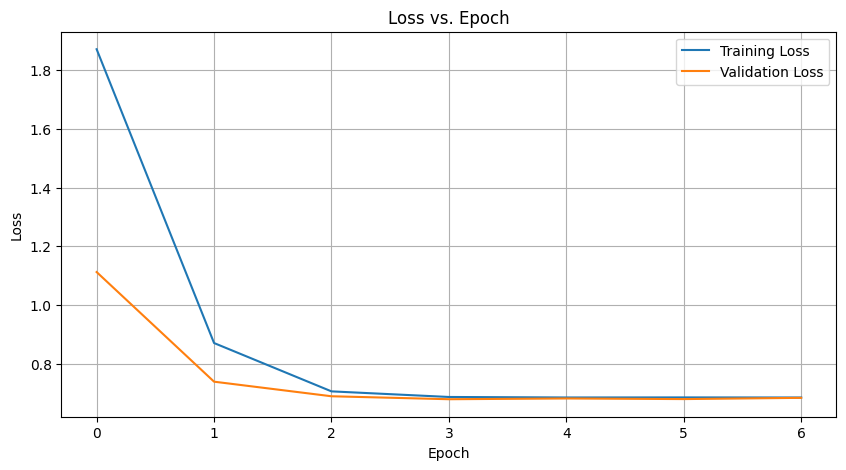

In [54]:
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

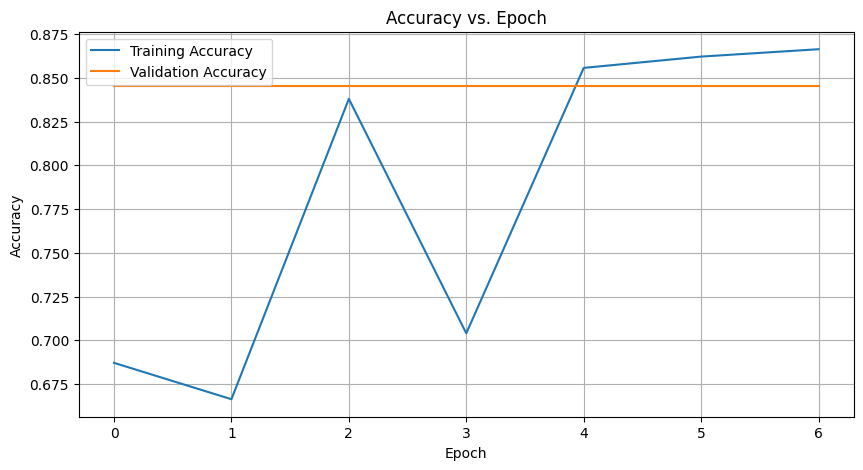

In [55]:
plt.figure(figsize=(10, 5))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Evaluate Model

In [58]:
y_pred = model.predict(X_test)
auc_score = roc_auc_score(y_test, y_pred)
print(f"Test ROC-AUC: {auc_score:.4f}")
print(f"Precision (Spam): {precision_score(y_test, y_pred > 0.5, pos_label=0):.4f}")
print(f"Recall (Spam): {recall_score(y_test, y_pred > 0.5, pos_label=0):.4f}")
print(f"F1-Score (Spam): {f1_score(y_test, y_pred > 0.5, pos_label=0):.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step
Test ROC-AUC: 0.6740
Precision (Spam): 0.0000
Recall (Spam): 0.0000
F1-Score (Spam): 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [59]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.8769 - loss: 0.6768
Test Accuracy: 0.8788


# Predict Func

In [62]:
def predict_spam(message, tokenizer, model, max_len):
    message = preprocess_text(message)
    sequence = tokenizer.texts_to_sequences([message])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    prediction = model.predict(padded)[0][0]
    return 'Spam' if prediction < 0.5 else 'Ham'

# Test
sample_message = "Win a free iPhone now! Text FREE to 12345"
print(f"Sample message prediction: {predict_spam(sample_message, tokenizer, model, MAX_SEQUENCES_LENGTH)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
Sample message prediction: Ham
